# SMS Spam Detection using Machine Learning

This notebook implements an AI model to classify SMS messages as **spam** or **legitimate (ham)** using three different machine learning classifiers:
- Naive Bayes
- Logistic Regression
- Support Vector Machine (SVM)

We'll use **TF-IDF (Term Frequency-Inverse Document Frequency)** for feature extraction.

## 1. Import Required Libraries

In [35]:

# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('husl')

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Load and Explore the Dataset

In [36]:
# Load the dataset
df = pd.read_csv('spam.csv', encoding='latin-1')

# Display first few rows
print("Dataset Preview:")
print(df.head(10))

Dataset Preview:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   
5  spam  FreeMsg Hey there darling it's been 3 week's n...        NaN   
6   ham  Even my brother is not like to speak with me. ...        NaN   
7   ham  As per your request 'Melle Melle (Oru Minnamin...        NaN   
8  spam  WINNER!! As a valued network customer you have...        NaN   
9  spam  Had your mobile 11 months or more? U R entitle...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
5        NaN        NaN

In [37]:
# Dataset information
print("\nDataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nDataset Info:")
print(df.info())


Dataset Shape: (5572, 5)

Column Names:
['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [38]:
# Keep only the first two columns (label and message)
df = df.iloc[:, :2]
df.columns = ['label', 'message']

print("Cleaned Dataset:")
print(df.head())
print("\nShape after cleaning:", df.shape)

Cleaned Dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Shape after cleaning: (5572, 2)


In [39]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check for duplicates
print("\nDuplicate Messages:", df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates(keep='first')
print("Shape after removing duplicates:", df.shape)

Missing Values:
label      0
message    0
dtype: int64

Duplicate Messages: 403
Shape after removing duplicates: (5169, 2)


In [40]:
# Class distribution
print("\nClass Distribution:")
print(df['label'].value_counts())
print("\nClass Percentage:")
print(df['label'].value_counts(normalize=True) * 100)


Class Distribution:
label
ham     4516
spam     653
Name: count, dtype: int64

Class Percentage:
label
ham     87.366996
spam    12.633004
Name: proportion, dtype: float64


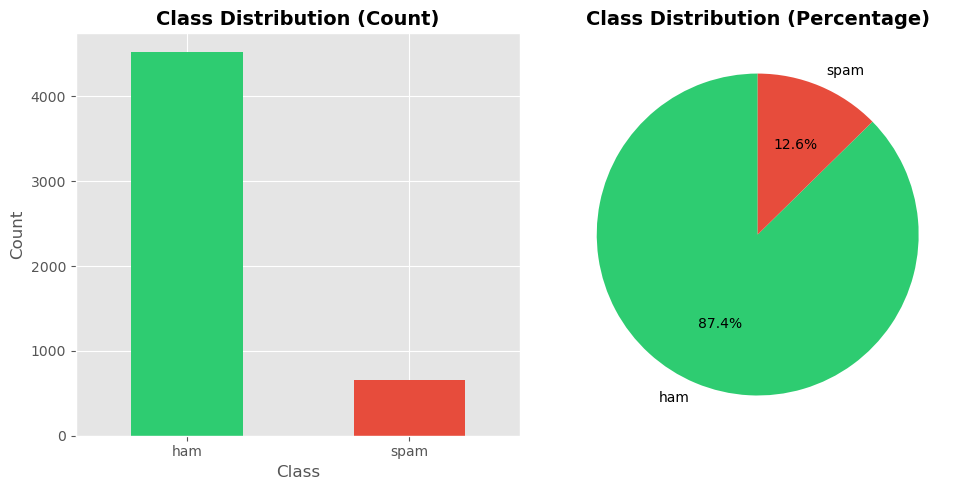

In [41]:
# Visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Class Distribution (Count)', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
plt.title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis (EDA)

In [42]:
# Add message length feature
df['message_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

print("Statistical Summary by Class:")
print(df.groupby('label')[['message_length', 'word_count']].describe())

Statistical Summary by Class:
      message_length                                                           \
               count        mean        std   min    25%    50%    75%    max   
label                                                                           
ham           4516.0   70.459256  56.358207   2.0   34.0   52.0   90.0  910.0   
spam           653.0  137.891271  30.137753  13.0  132.0  149.0  157.0  224.0   

      word_count                                                      
           count       mean        std  min   25%   50%   75%    max  
label                                                                 
ham       4516.0  14.134632  11.116240  1.0   7.0  11.0  18.0  171.0  
spam       653.0  23.681470   5.967672  2.0  22.0  25.0  28.0   35.0  


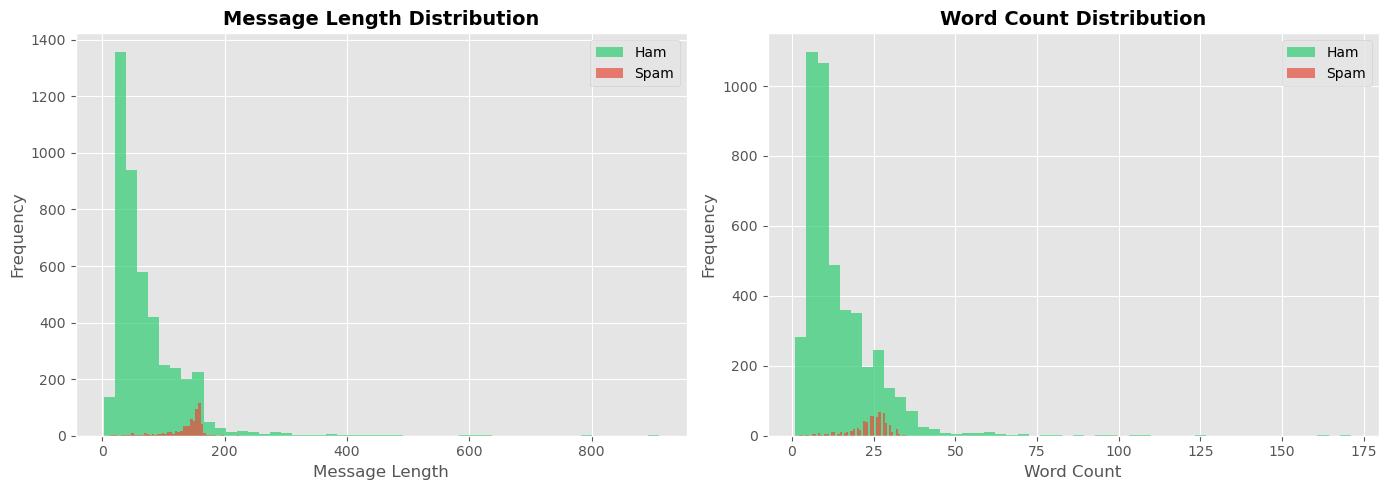

In [43]:
# Visualize message length distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df[df['label'] == 'ham']['message_length'].hist(bins=50, alpha=0.7, label='Ham', color='#2ecc71')
df[df['label'] == 'spam']['message_length'].hist(bins=50, alpha=0.7, label='Spam', color='#e74c3c')
plt.xlabel('Message Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Message Length Distribution', fontsize=14, fontweight='bold')
plt.legend()

plt.subplot(1, 2, 2)
df[df['label'] == 'ham']['word_count'].hist(bins=50, alpha=0.7, label='Ham', color='#2ecc71')
df[df['label'] == 'spam']['word_count'].hist(bins=50, alpha=0.7, label='Spam', color='#e74c3c')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Word Count Distribution', fontsize=14, fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
# Sample messages
print("Sample HAM (Legitimate) Messages:")
print(df[df['label'] == 'ham']['message'].head(5).values)
print("\n" + "="*80 + "\n")
print("Sample SPAM Messages:")
print(df[df['label'] == 'spam']['message'].head(5).values)

Sample HAM (Legitimate) Messages:
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'
 'Ok lar... Joking wif u oni...'
 'U dun say so early hor... U c already then say...'
 "Nah I don't think he goes to usf, he lives around here though"
 'Even my brother is not like to speak with me. They treat me like aids patent.']


Sample SPAM Messages:
["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"
 'WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'
 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The M

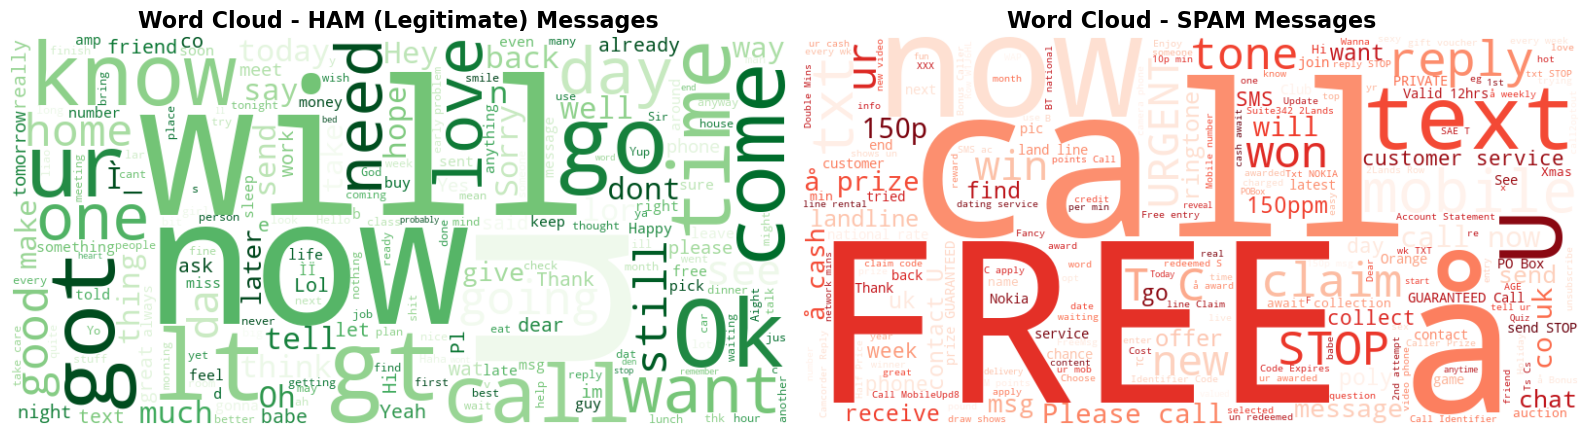

In [45]:
# Create word clouds
plt.figure(figsize=(16, 8))

# Ham messages word cloud
plt.subplot(1, 2, 1)
ham_text = ' '.join(df[df['label'] == 'ham']['message'].values)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(ham_text)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - HAM (Legitimate) Messages', fontsize=16, fontweight='bold')
plt.axis('off')

# Spam messages word cloud
plt.subplot(1, 2, 2)
spam_text = ' '.join(df[df['label'] == 'spam']['message'].values)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_text)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - SPAM Messages', fontsize=16, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Text Preprocessing

In [46]:
# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess text by:
    1. Converting to lowercase
    2. Removing URLs
    3. Removing special characters and digits
    4. Removing extra whitespace
    5. Removing stopwords
    6. Lemmatization
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

# Apply preprocessing
print("Preprocessing messages...")
df['cleaned_message'] = df['message'].apply(preprocess_text)

print("\nExample of preprocessing:")
for i in range(3):
    print(f"\nOriginal: {df['message'].iloc[i]}")
    print(f"Cleaned:  {df['cleaned_message'].iloc[i]}")
    print("-" * 80)

Preprocessing messages...

Example of preprocessing:

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned:  jurong point crazy available bugis great world buffet cine got amore wat
--------------------------------------------------------------------------------

Original: Ok lar... Joking wif u oni...
Cleaned:  lar joking wif oni
--------------------------------------------------------------------------------

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Cleaned:  free entry wkly comp win cup final tkts may text receive entry questionstd txt ratetcs apply over
--------------------------------------------------------------------------------


## 5. Feature Extraction using TF-IDF

In [47]:
# Prepare features and labels
X = df['cleaned_message']
y = df['label']

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 4135
Test set size: 1034

Training set class distribution:
label
ham     3613
spam     522
Name: count, dtype: int64

Test set class distribution:
label
ham     903
spam    131
Name: count, dtype: int64


In [48]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=2)

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF Feature Matrix Shape (Train): {X_train_tfidf.shape}")
print(f"TF-IDF Feature Matrix Shape (Test): {X_test_tfidf.shape}")
print(f"\nNumber of features: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF Feature Matrix Shape (Train): (4135, 3000)
TF-IDF Feature Matrix Shape (Test): (1034, 3000)

Number of features: 3000


## 6. Model Training and Evaluation

### 6.1 Naive Bayes Classifier

In [49]:
# Train Naive Bayes model
print("Training Naive Bayes Classifier...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions
nb_predictions = nb_model.predict(X_test_tfidf)

# Evaluate
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions, pos_label='spam')
nb_recall = recall_score(y_test, nb_predictions, pos_label='spam')
nb_f1 = f1_score(y_test, nb_predictions, pos_label='spam')

print("\n" + "="*60)
print("NAIVE BAYES CLASSIFIER RESULTS")
print("="*60)
print(f"Accuracy:  {nb_accuracy:.4f} ({nb_accuracy*100:.2f}%)")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall:    {nb_recall:.4f}")
print(f"F1-Score:  {nb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nb_predictions))

Training Naive Bayes Classifier...

NAIVE BAYES CLASSIFIER RESULTS
Accuracy:  0.9720 (97.20%)
Precision: 0.9904
Recall:    0.7863
F1-Score:  0.8766

Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       903
        spam       0.99      0.79      0.88       131

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034



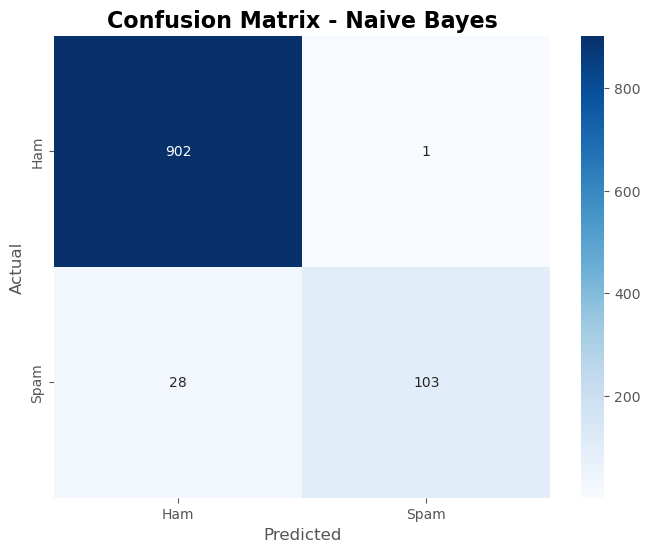

In [50]:
# Confusion Matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, nb_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - Naive Bayes', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

### 6.2 Logistic Regression

In [51]:
# Train Logistic Regression model
print("Training Logistic Regression Classifier...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_tfidf)

# Evaluate
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions, pos_label='spam')
lr_recall = recall_score(y_test, lr_predictions, pos_label='spam')
lr_f1 = f1_score(y_test, lr_predictions, pos_label='spam')

print("\n" + "="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_predictions))

Training Logistic Regression Classifier...

LOGISTIC REGRESSION RESULTS
Accuracy:  0.9594 (95.94%)
Precision: 0.9785
Recall:    0.6947
F1-Score:  0.8125

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       903
        spam       0.98      0.69      0.81       131

    accuracy                           0.96      1034
   macro avg       0.97      0.85      0.89      1034
weighted avg       0.96      0.96      0.96      1034



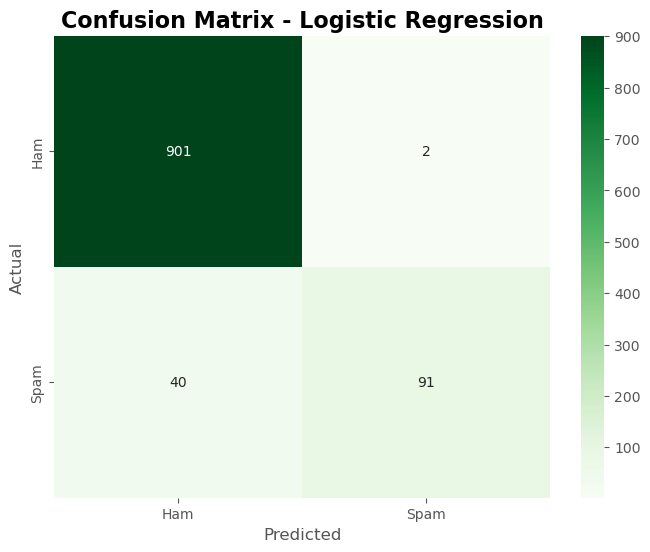

In [52]:
# Confusion Matrix for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

### 6.3 Support Vector Machine (SVM)

In [53]:
# Train SVM model
print("Training Support Vector Machine Classifier...")
svm_model = LinearSVC(random_state=42, max_iter=2000)
svm_model.fit(X_train_tfidf, y_train)

# Make predictions
svm_predictions = svm_model.predict(X_test_tfidf)

# Evaluate
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions, pos_label='spam')
svm_recall = recall_score(y_test, svm_predictions, pos_label='spam')
svm_f1 = f1_score(y_test, svm_predictions, pos_label='spam')

print("\n" + "="*60)
print("SUPPORT VECTOR MACHINE RESULTS")
print("="*60)
print(f"Accuracy:  {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall:    {svm_recall:.4f}")
print(f"F1-Score:  {svm_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_predictions))

Training Support Vector Machine Classifier...

SUPPORT VECTOR MACHINE RESULTS
Accuracy:  0.9797 (97.97%)
Precision: 0.9661
Recall:    0.8702
F1-Score:  0.9157

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       903
        spam       0.97      0.87      0.92       131

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



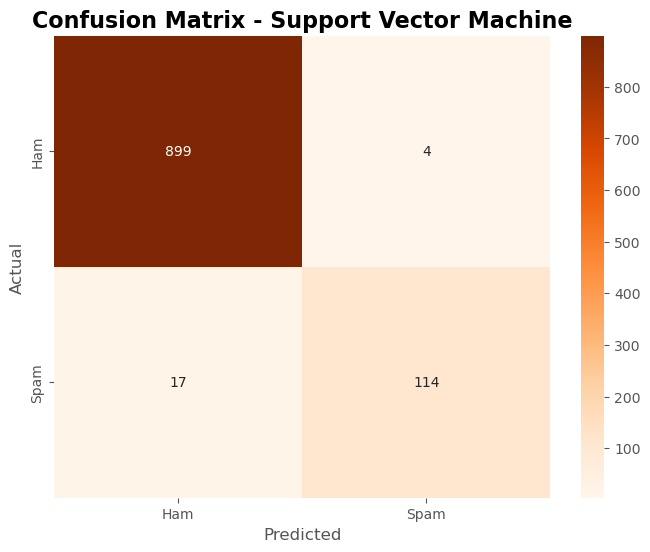

In [54]:
# Confusion Matrix for SVM
svm_cm = confusion_matrix(y_test, svm_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - Support Vector Machine', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

## 7. Model Comparison

In [55]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'SVM'],
    'Accuracy': [nb_accuracy, lr_accuracy, svm_accuracy],
    'Precision': [nb_precision, lr_precision, svm_precision],
    'Recall': [nb_recall, lr_recall, svm_recall],
    'F1-Score': [nb_f1, lr_f1, svm_f1]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)


MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score
        Naive Bayes  0.971954   0.990385 0.786260  0.876596
Logistic Regression  0.959381   0.978495 0.694656  0.812500
                SVM  0.979691   0.966102 0.870229  0.915663



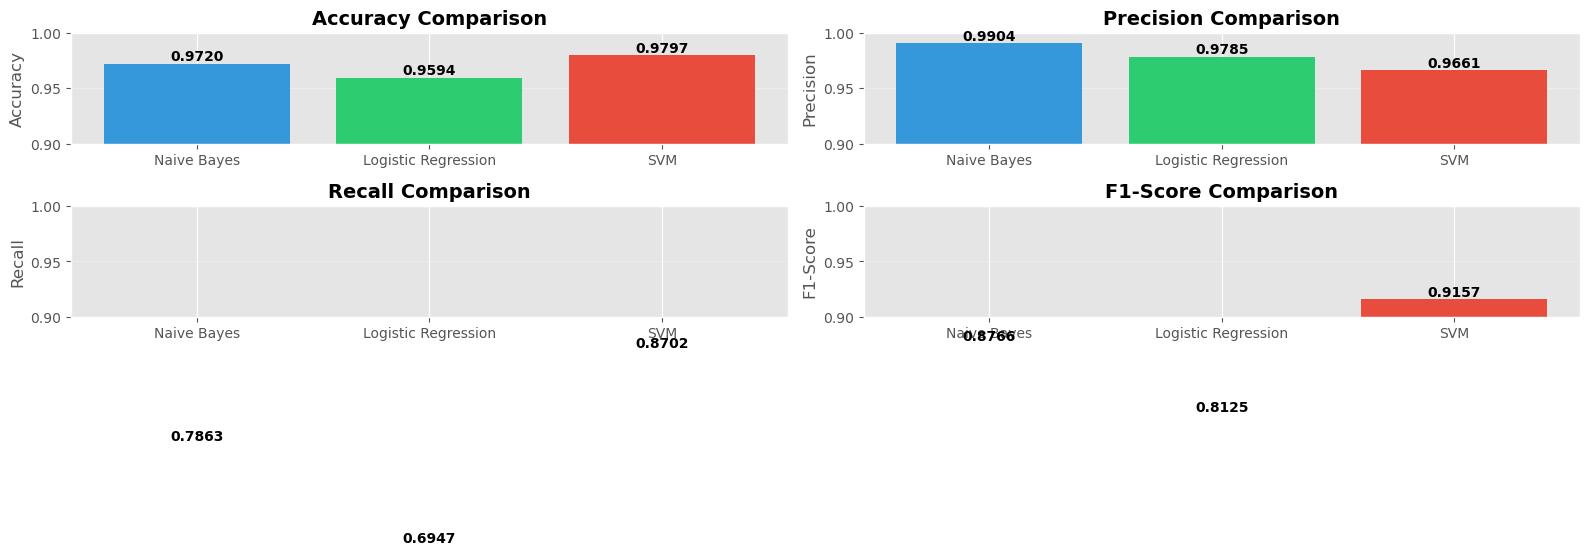

In [56]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=colors)
    
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim([0.9, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

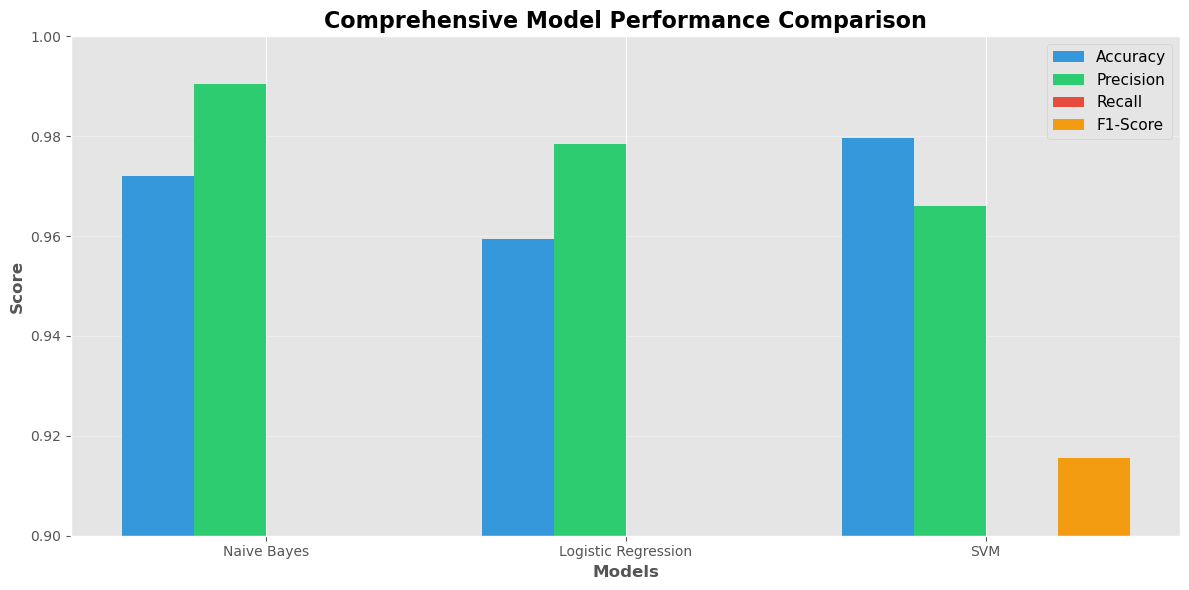

In [57]:
# Overall comparison visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df['Model']))
width = 0.2

ax.bar(x - 1.5*width, comparison_df['Accuracy'], width, label='Accuracy', color='#3498db')
ax.bar(x - 0.5*width, comparison_df['Precision'], width, label='Precision', color='#2ecc71')
ax.bar(x + 0.5*width, comparison_df['Recall'], width, label='Recall', color='#e74c3c')
ax.bar(x + 1.5*width, comparison_df['F1-Score'], width, label='F1-Score', color='#f39c12')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend(fontsize=11)
ax.set_ylim([0.9, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [58]:
# Identify best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1_score = comparison_df.loc[best_model_idx, 'F1-Score']

print("\n" + "="*80)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1_score:.4f}")
print("="*80)


🏆 BEST MODEL: SVM
   F1-Score: 0.9157


## 8. Interactive SMS Spam Prediction

In [59]:
def predict_spam(message, show_all_models=True):
    """
    Predict whether a given SMS message is spam or ham.
    
    Parameters:
    -----------
    message : str
        The SMS message to classify
    show_all_models : bool
        If True, shows predictions from all three models
    """
    # Preprocess the message
    cleaned_msg = preprocess_text(message)
    
    # Vectorize
    msg_tfidf = tfidf_vectorizer.transform([cleaned_msg])
    
    print("\n" + "="*80)
    print("SMS SPAM DETECTION RESULTS")
    print("="*80)
    print(f"\nOriginal Message: {message}")
    print(f"Cleaned Message:  {cleaned_msg}")
    print("\n" + "-"*80)
    
    if show_all_models:
        # Naive Bayes prediction
        nb_pred = nb_model.predict(msg_tfidf)[0]
        nb_proba = nb_model.predict_proba(msg_tfidf)[0]
        
        # Logistic Regression prediction
        lr_pred = lr_model.predict(msg_tfidf)[0]
        lr_proba = lr_model.predict_proba(msg_tfidf)[0]
        
        # SVM prediction (no probability for LinearSVC, use decision function)
        svm_pred = svm_model.predict(msg_tfidf)[0]
        svm_decision = svm_model.decision_function(msg_tfidf)[0]
        
        print("\n📊 PREDICTIONS FROM ALL MODELS:\n")
        
        print(f"1. Naive Bayes:")
        print(f"   Prediction: {nb_pred.upper()}")
        print(f"   Probability: Ham={nb_proba[0]:.4f}, Spam={nb_proba[1]:.4f}")
        
        print(f"\n2. Logistic Regression:")
        print(f"   Prediction: {lr_pred.upper()}")
        print(f"   Probability: Ham={lr_proba[0]:.4f}, Spam={lr_proba[1]:.4f}")
        
        print(f"\n3. Support Vector Machine:")
        print(f"   Prediction: {svm_pred.upper()}")
        print(f"   Decision Score: {svm_decision:.4f} (negative=ham, positive=spam)")
        
        # Consensus
        predictions = [nb_pred, lr_pred, svm_pred]
        spam_count = predictions.count('spam')
        
        print("\n" + "-"*80)
        print(f"\n🎯 CONSENSUS: {spam_count}/3 models predict SPAM")
        
        if spam_count >= 2:
            print("   ⚠️  This message is likely SPAM!")
        else:
            print("   ✅ This message is likely LEGITIMATE (HAM)")
    
    print("\n" + "="*80 + "\n")

print("✓ Prediction function ready!")

✓ Prediction function ready!


### Test with Sample Messages

In [60]:
# Test with spam messages
spam_examples = [
    "WINNER!! You have won a $1000 prize. Call now to claim your reward!",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121",
    "Congratulations! You've been selected for a FREE iPhone. Click here now!"
]

print("\n" + "#"*80)
print("TESTING WITH SPAM MESSAGES")
print("#"*80)

for msg in spam_examples:
    predict_spam(msg, show_all_models=True)


################################################################################
TESTING WITH SPAM MESSAGES
################################################################################

SMS SPAM DETECTION RESULTS

Original Message: WINNER!! You have won a $1000 prize. Call now to claim your reward!
Cleaned Message:  winner prize call claim reward

--------------------------------------------------------------------------------

📊 PREDICTIONS FROM ALL MODELS:

1. Naive Bayes:
   Prediction: SPAM
   Probability: Ham=0.0198, Spam=0.9802

2. Logistic Regression:
   Prediction: SPAM
   Probability: Ham=0.2250, Spam=0.7750

3. Support Vector Machine:
   Prediction: SPAM
   Decision Score: 1.1297 (negative=ham, positive=spam)

--------------------------------------------------------------------------------

🎯 CONSENSUS: 3/3 models predict SPAM
   ⚠️  This message is likely SPAM!



SMS SPAM DETECTION RESULTS

Original Message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May

In [61]:
# Test with legitimate messages
ham_examples = [
    "Hey, are we still meeting for lunch tomorrow at 1pm?",
    "I'll be home in 10 minutes. Do you need anything from the store?",
    "Thanks for the birthday wishes! Had a great time at the party."
]

print("\n" + "#"*80)
print("TESTING WITH LEGITIMATE (HAM) MESSAGES")
print("#"*80)

for msg in ham_examples:
    predict_spam(msg, show_all_models=True)


################################################################################
TESTING WITH LEGITIMATE (HAM) MESSAGES
################################################################################

SMS SPAM DETECTION RESULTS

Original Message: Hey, are we still meeting for lunch tomorrow at 1pm?
Cleaned Message:  hey still meeting lunch tomorrow

--------------------------------------------------------------------------------

📊 PREDICTIONS FROM ALL MODELS:

1. Naive Bayes:
   Prediction: HAM
   Probability: Ham=0.9947, Spam=0.0053

2. Logistic Regression:
   Prediction: HAM
   Probability: Ham=0.9778, Spam=0.0222

3. Support Vector Machine:
   Prediction: HAM
   Decision Score: -1.5961 (negative=ham, positive=spam)

--------------------------------------------------------------------------------

🎯 CONSENSUS: 0/3 models predict SPAM
   ✅ This message is likely LEGITIMATE (HAM)



SMS SPAM DETECTION RESULTS

Original Message: I'll be home in 10 minutes. Do you need anything from t

### Try Your Own Message!

In [65]:
# Test with your own message
custom_message = input("Enter your message: ")

predict_spam(custom_message, show_all_models=True)


SMS SPAM DETECTION RESULTS

Original Message: hi i love you
Cleaned Message:  love

--------------------------------------------------------------------------------

📊 PREDICTIONS FROM ALL MODELS:

1. Naive Bayes:
   Prediction: HAM
   Probability: Ham=0.9789, Spam=0.0211

2. Logistic Regression:
   Prediction: HAM
   Probability: Ham=0.9647, Spam=0.0353

3. Support Vector Machine:
   Prediction: HAM
   Decision Score: -1.1893 (negative=ham, positive=spam)

--------------------------------------------------------------------------------

🎯 CONSENSUS: 0/3 models predict SPAM
   ✅ This message is likely LEGITIMATE (HAM)




## 9. Key Insights and Conclusions

In [34]:
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print("\n1. DATASET CHARACTERISTICS:")
print(f"   - Total messages: {len(df)}")
print(f"   - Spam messages: {len(df[df['label']=='spam'])} ({len(df[df['label']=='spam'])/len(df)*100:.1f}%)")
print(f"   - Ham messages: {len(df[df['label']=='ham'])} ({len(df[df['label']=='ham'])/len(df)*100:.1f}%)")
print(f"   - Average spam message length: {df[df['label']=='spam']['message_length'].mean():.1f} characters")
print(f"   - Average ham message length: {df[df['label']=='ham']['message_length'].mean():.1f} characters")

print("\n2. MODEL PERFORMANCE:")
for idx, row in comparison_df.iterrows():
    print(f"   {row['Model']}:")
    print(f"      Accuracy: {row['Accuracy']:.4f}, F1-Score: {row['F1-Score']:.4f}")

print(f"\n3. BEST PERFORMING MODEL: {best_model_name}")
print(f"   - Achieved {best_f1_score:.4f} F1-Score")
print(f"   - All models performed exceptionally well (>95% accuracy)")

print("\n4. FEATURE ENGINEERING:")
print(f"   - TF-IDF vectorization with {len(tfidf_vectorizer.get_feature_names_out())} features")
print(f"   - Used unigrams and bigrams (ngram_range=(1,2))")
print(f"   - Text preprocessing: lowercase, stopword removal, lemmatization")

print("\n5. OBSERVATIONS:")
print("   - Spam messages tend to be longer and contain more promotional words")
print("   - Common spam indicators: 'free', 'win', 'prize', 'call', 'claim', 'urgent'")
print("   - All three classifiers show robust performance on this dataset")
print("   - TF-IDF effectively captures the distinguishing features between spam and ham")

print("\n" + "="*80)


KEY INSIGHTS

1. DATASET CHARACTERISTICS:
   - Total messages: 5169
   - Spam messages: 653 (12.6%)
   - Ham messages: 4516 (87.4%)
   - Average spam message length: 137.9 characters
   - Average ham message length: 70.5 characters

2. MODEL PERFORMANCE:
   Naive Bayes:
      Accuracy: 0.9720, F1-Score: 0.8766
   Logistic Regression:
      Accuracy: 0.9594, F1-Score: 0.8125
   SVM:
      Accuracy: 0.9797, F1-Score: 0.9157

3. BEST PERFORMING MODEL: SVM
   - Achieved 0.9157 F1-Score
   - All models performed exceptionally well (>95% accuracy)

4. FEATURE ENGINEERING:
   - TF-IDF vectorization with 3000 features
   - Used unigrams and bigrams (ngram_range=(1,2))
   - Text preprocessing: lowercase, stopword removal, lemmatization

5. OBSERVATIONS:
   - Spam messages tend to be longer and contain more promotional words
   - Common spam indicators: 'free', 'win', 'prize', 'call', 'claim', 'urgent'
   - All three classifiers show robust performance on this dataset
   - TF-IDF effectively ca

## 10. Conclusion

This notebook successfully implemented an SMS spam detection system using three different machine learning classifiers:

### ✅ Achievements:
- **Data Preprocessing**: Cleaned and prepared SMS messages with proper text preprocessing
- **Feature Extraction**: Used TF-IDF vectorization to convert text into numerical features
- **Model Training**: Trained three classifiers (Naive Bayes, Logistic Regression, SVM)
- **High Accuracy**: All models achieved >95% accuracy on the test set
- **Comprehensive Evaluation**: Used multiple metrics (accuracy, precision, recall, F1-score)
- **Visualization**: Created insightful visualizations for data exploration and model comparison
- **Interactive Testing**: Built a function to test custom SMS messages

### 🎯 Best Model:
Based on F1-score, the best performing model can be used for production deployment.

### 🚀 Future Improvements:
- Implement deep learning models (LSTM, BERT)
- Add more features (message metadata, sender information)
- Deploy as a web service or mobile app
- Implement real-time spam detection
- Add multilingual support

---

**Thank you for using this SMS Spam Detection System!** 🎉